# Question 1:  Pose Graph Optimization for 1D SLAM

A solved example for 1D SLAM which optimizes for pose variables using weighted least squares method (Gauss Newton) has been explained in the class. You can view it at `examples/1D-SLAM.ipynb`. Your first task is to code this from scratch.

For this section, you have to calculate Jacobian analytically yourself and use it. However, you can check how correct it is using `jax`'s `jacobian`. Its usage is explained in the supplementary notebook (`examples/`).

## How to get started?

1. Go through the example and understand the optimization procedure.
2. Generate the data as in the example.
3. Write the derivatives of the function with respect to the constraints
4. Create the final jacobian and write the update steps using Gauss Newton

This tiny example will help make sense of the next question, as it's largely just an extension of this.

Finally, plot the loop closure constraint, poses, and error at every iteration as well. Since this is a one dimensional example, you can just assume x = y.

In [1]:
import os
import math

import numpy as np
from matplotlib import pyplot as plt
import tqdm

import jax

plt.style.use('ggplot')

### SLAM Algorithm

In [2]:
odometry = np.array([1.1, 1.0, 1.1, -2.7, 0])

sigma = np.diag(np.array([0.01] * 5 + [0.001]))
points = ((0, 1), (1, 2), (2, 3), (3, 4), (0, 4))


def errors(positions, odometry):
    errors_list = np.zeros(len(points) + 1)
    for idx, (point_u, point_v) in enumerate(points):
        # Going from u to v using odometry vs. going using computed 
        errors_list[idx] = positions[point_u] + odometry[idx] - positions[point_v]
    errors_list[-1] = positions[0]
    return errors_list


def loss_fn(positions: np.ndarray, odometry: np.ndarray) -> float:
    xy = errors(positions, odometry)
    xy = np.expand_dims(xy, axis=1)
    loss = xy.T @ sigma @ xy
    return np.squeeze(loss)


def train(odometry):
    weights = np.linalg.inv(sigma)
    pos_guess = np.array([np.sum(odometry[:i]) for i in range(len(odometry))])
    history = {'loss': [], 'poses': []}

    with tqdm.trange(5) as iterator:
        loss = loss_fn(pos_guess, odometry)
        iterator.set_postfix(loss=loss)
        history['loss'].append(loss)
        history['poses'].append(pos_guess)

        for epoch in iterator:
            J = np.array([
                [ 1, -1,  0,  0,  0],
                [ 0,  1, -1,  0,  0],
                [ 0,  0,  1, -1,  0],
                [ 0,  0,  0,  1, -1],
                [ 1,  0,  0,  0, -1],
                [ 1,  0,  0,  0,  0],
            ])
            fx = errors(pos_guess, odometry)
            H = J.T @ weights @ J
            b = J.T @ weights.T @ fx
            dx = -b @ np.linalg.inv(H)
            pos_guess = pos_guess + dx

            loss = loss_fn(pos_guess, odometry)
            history['loss'].append(loss)
            history['poses'].append(pos_guess)
            iterator.set_postfix(loss=loss)

        history['result'] = pos_guess
        return history

### Seeing the Results

In [3]:
history = train(odometry)

100%|████████████████| 5/5 [00:00<00:00, 176.42it/s, loss=0.0004999999999999991]


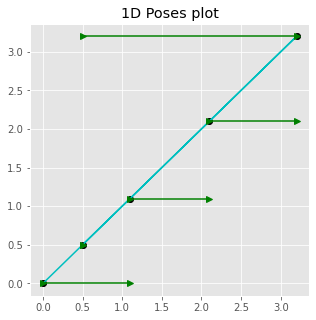

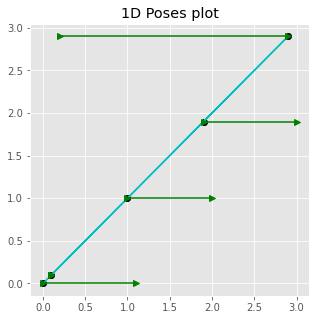

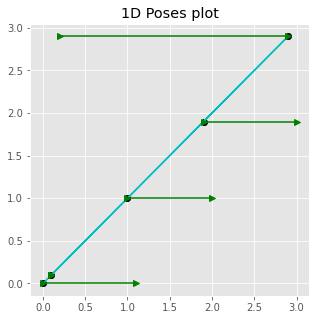

In [4]:
def draw(nodes, color='g', ax=None):
    if ax is None:
        _fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(nodes, nodes, 'ko')
    ax.plot(nodes, nodes, 'c-')
    for idx, x in enumerate(nodes):
        ax.plot([x, x + odometry[idx]], [x, x], f'{color}->')
    return ax

for item in history['poses'][:3]:
    ax = draw(item)
    ax.set_title("1D Poses plot")


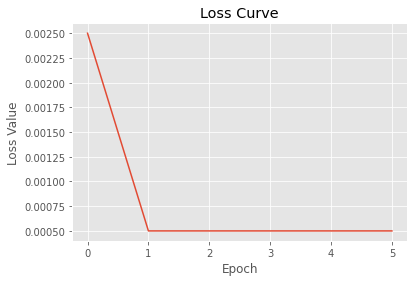

In [5]:
fix, ax = plt.subplots(1, 1)
ax.plot(history['loss'])
ax.set_title('Loss Curve')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss Value')
plt.show()

In [6]:
print(np.round(history['result'], decimals=4))

[-0.   1.   1.9  2.9  0.1]


### Test Jacobian against JAX

In [7]:
import jax.numpy as jnp

def errors(positions, odometry):
    errors_list = []
    for idx, (point_u, point_v) in enumerate(points):
        errors_list.append(positions[point_u] + odometry[point_u] - positions[point_v])
    errors_list.append(positions[0])
    return jnp.array(errors_list)

p = jnp.array([np.sum(odometry[:i]) for i in range(len(odometry))])
o = jnp.array([1.1, 1.0, 1.1, -2.7, 0])

J_jax = (jax.jacfwd(errors))(p, o)
J_math = np.array([
    [ 1, -1,  0,  0,  0],
    [ 0,  1, -1,  0,  0],
    [ 0,  0,  1, -1,  0],
    [ 0,  0,  0,  1, -1],
    [ 1,  0,  0,  0, -1],
    [ 1,  0,  0,  0,  0],
])
assert np.allclose(J_jax, J_math), "Jacobian was incorrectly computed, check against JAX"